# Bibliotecas

Nesta seção vamos instalar todas as bibliotecas utilizadas.

Além do OpenStreetMap, foram utilizadas: geopandas, pandas e networkx, mas estas já estão disponíveis no jupyter.

In [108]:
!pip install osmnx

# Preparação

Nesta seção, vamos preparar o grafo com os dados recolhidos [neste repositório](https://github.com/lemuel-manske/city-block/tree/main/data) e organizar vértices e arestas por bairro.

1. Gerar o grafo de Blumenau, cidade escolhida pela equipe para realizar o trabalho:

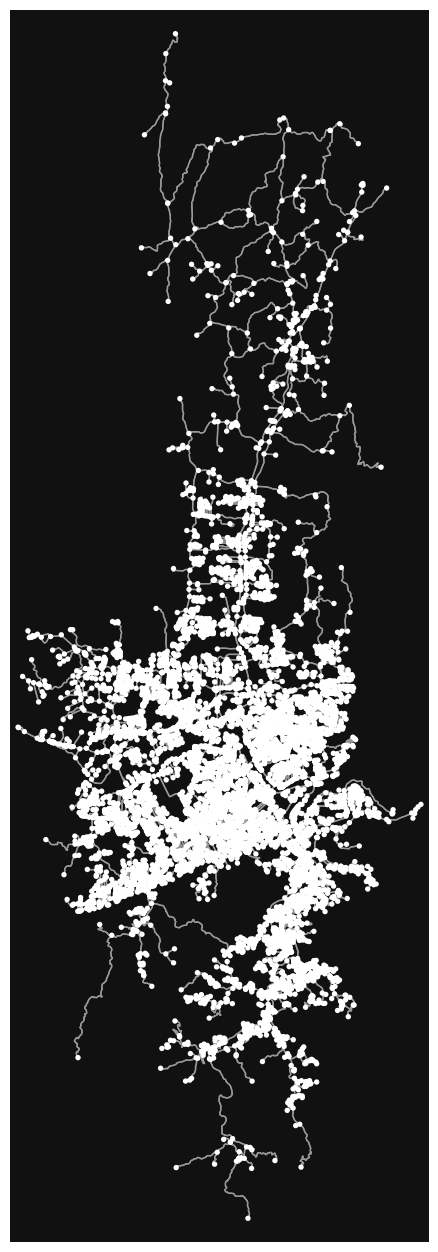

(<Figure size 1600x1600 with 1 Axes>, <Axes: >)

In [109]:
import osmnx as ox

PLACE = 'Blumenau, Brazil'

G = ox.graph_from_place(
    PLACE,
    network_type='drive'
)

ox.plot_graph(G, figsize=(16, 16))

2. Importar os dados recolhidos para o grafo. Para este processo, foram coletadas longitude - `x` - e latitude - `y` - de cada ponto de interesse e no grafo vamos atribuir um "label" e "nome" para o vértice mais próximo ao ponto de interesse desejado. Todos os datasets estão disponíveis [neste repositório](http://github.com/lemuel-manske/city-block/data)
  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes

In [110]:
import pandas as pd
import networkx as nx

"""
  Labels with `label` the nodes of interest from a `dataframe` in a graph `G`.

  Tags are the information that the node needs to store for
  post processing, e.g. `student_name`.
"""
def label_points_of_interest(G: nx.MultiDiGraph, dataframe: pd.DataFrame, label: str, *tags):
  for idx, row in dataframe.iterrows():
    x = row['x']
    y = row['y']

    nearest_node_from_interest_point = ox.distance.nearest_nodes(G, X=x, Y=y)

    G.nodes[nearest_node_from_interest_point]['label'] = label

    for tag in tags:
      G.nodes[nearest_node_from_interest_point][tag] = row[tag]

DATA_FRAMES = {
    'hospital': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/hospitals.csv',
    'student': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/students.csv'
}

def load_students():
  label = 'student'
  df = pd.read_csv(DATA_FRAMES[label])
  label_points_of_interest(G, df, label, 'name', 'student_name')

def load_hospitals():
  label = 'hospital'
  df = pd.read_csv(DATA_FRAMES[label])
  label_points_of_interest(G, df, label, 'name', 'is_public')

load_students()
load_hospitals()

3. Afim de facilitar a análise, vamos separar todas os vértices e arestas por bairro. Foi necessário remover os bairros que não são reconhecidos na divisão administrativa feita pela prefeitura [neste link](https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros) mas que o OSM reconhece.

  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place
  - https://wiki.openstreetmap.org/wiki/Key:admin_level

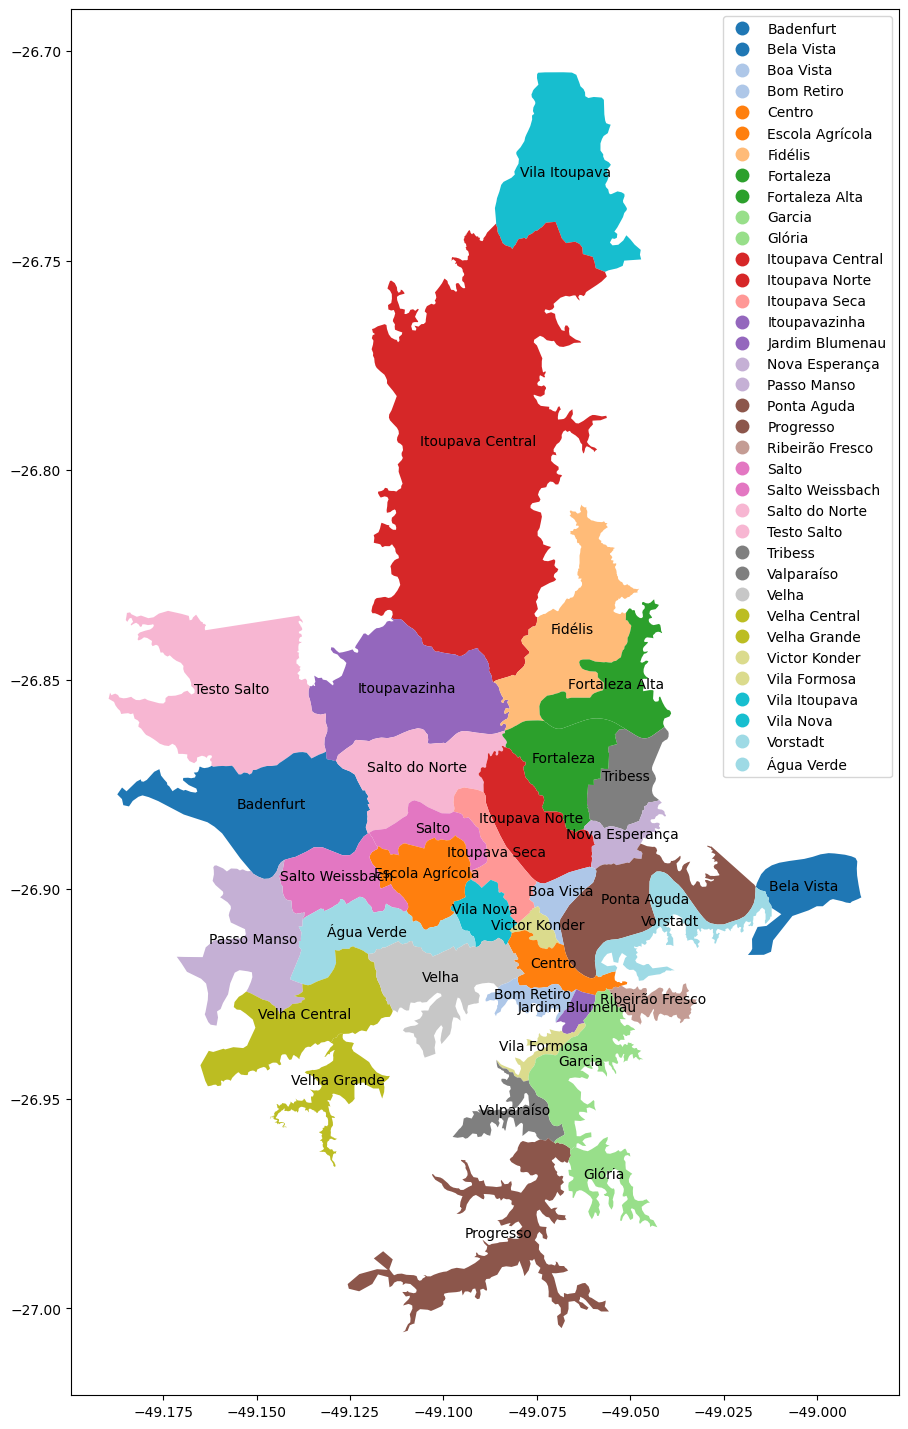

In [111]:
import osmnx as ox

import matplotlib.pyplot as plt

PLACE = 'Blumenau, Brazil'

NOT_DESIRED_NEIGHBORHOODS = [
    'Belchior Baixo',
    'Belchior Alto',
    'Belchior Central',
    'Gaspar Alto',
    'Gaspar Grande',
    'Figueira',
    'Encano do Norte',
    'Encano Baixo',
    'Encano Central',
    'Encano Alto',
    'Sternthal',
    'Gruenerwinkel',
    'Planície Alta',
    'Treze de Maio',
    'Ribeirão Humberto',
    'Rio Bonito',
    'Terceiro Braço',
    'Sete de Janeiro',
]

neighborhood_tags = { 'admin_level': '10' }

neighborhoods = ox.features \
  .features_from_place(PLACE, { 'admin_level': '10' }) \
  .query(f'name not in {NOT_DESIRED_NEIGHBORHOODS}')

neighborhoods.plot(column='name', cmap='tab20', legend=True, figsize=(12, 18))

neighborhoods.apply(lambda p: plt.annotate(text=p['name'], xy=p.geometry.centroid.coords[0], ha='center'), axis=1);

4. Com o geopandas, podemos fazer um [*spatial join*](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) dos vértices - `G_nodes` - do grafo original que sobrepoem - `predicate='intersects'` - qualquer polígono - `neighborhoods[['geometry']]`. Por fim, renomeamos a coluna de `name_right` para `name` para manter consistência. A saída são todos os vértices de `G`, porém agora estão identificados por bairro.

 - https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html


In [112]:
import geopandas as gpd

import osmnx as ox

G_nodes, G_edges = ox.graph_to_gdfs(G) # MultiDiGraph to GeoDataFrame

nodes_with_neighborhood = gpd \
  .sjoin(G_nodes, neighborhoods[['name', 'geometry']], how='left', predicate='intersects') \
  .rename(columns={'name_right': 'name'})

5. Vamos modificar o grafo original `G` atribuindo a cada vértice seu respectivo bairro:

In [113]:
neighborhoods_dict = nodes_with_neighborhood['name'].to_dict()

nx.set_node_attributes(G, neighborhoods_dict, 'neighborhood_name')

6. E filtrando vértices do bairro "Centro", temos um subgrafo que representa o Centro de Blumenau.

  1. Para melhorar a exibição, utilizando pyplot podemos exibir o conjunto: polígono + grafo, resultando em:

<Axes: >

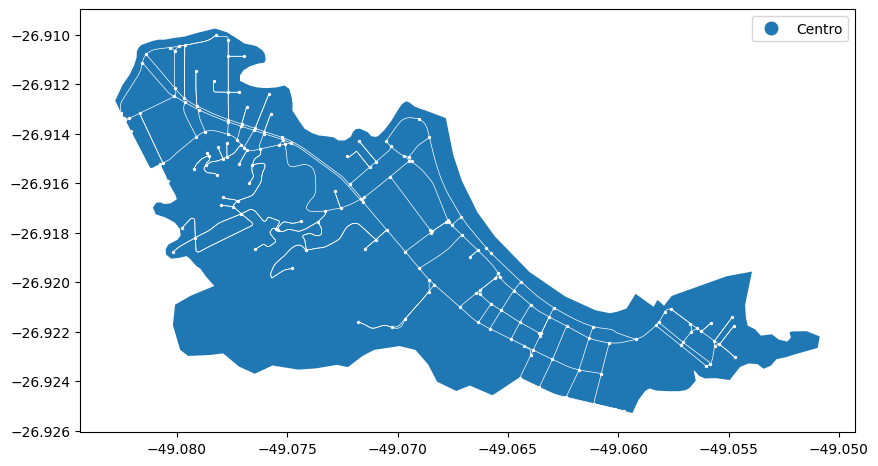

In [114]:
import matplotlib.pyplot as plt

list_to_filter = ['Centro']

fig, ax = plt.subplots(figsize=(10, 10))

G_sub_downtown = G \
  .subgraph(nodes_with_neighborhood[nodes_with_neighborhood['name'].isin(list_to_filter)].index) \
  .copy()

# plotting polygon - first layer
GDF_downtown = neighborhoods[neighborhoods['name'].isin(list_to_filter)]

GDF_downtown.plot(ax=ax, column='name', cmap='tab20', legend=True)

# plotting graph (nodes & edges) - second layer
G_downtown_nodes, G_downtown_edges = ox.graph_to_gdfs(G_sub_downtown)

G_downtown_edges.plot(ax=ax, linewidth=0.5, color='w')
G_downtown_nodes.plot(ax=ax, markersize=2, color='w')

# Análise

Nesta seção vamos gerar informações a partir dos dados coletados anteriormente.

In [151]:
import folium as fl
import geopandas as gpd

from ipywidgets import interact

def line_off_neighborhoods(m):
  fields = ['name']

  fl.GeoJson(
    neighborhoods.to_json(),
    name='Bairros',

    tooltip=fl.GeoJsonTooltip(labels=False, fields=fields, max_width=100)
  ).add_to(m)

def mark_out_student_nodes(m, nodes):
  fields = ['student_name', 'name', 'neighborhood_name']

  style = lambda feature: {

  }

  fl.GeoJson(
    nodes.to_json(),
    name='Estudantes',

    tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100),

    style_function=style
  ).add_to(m)

G_nodes, _ = ox.graph_to_gdfs(G)

G_student_nodes = G_nodes[G_nodes['label'] == 'student']

center = G_student_nodes.geometry.union_all().centroid

m = fl.Map(location=[center.y, center.x], zoom_start=14)

line_off_neighborhoods(m)
mark_out_student_nodes(m, G_student_nodes)

fl.LayerControl().add_to(m)

m